In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import utils, hf

s0 = np.identity(2)
sz = np.diag([1, -1])

norbs=2


graphene = kwant.lattice.general(
    [[1, 0], [1 / 2, np.sqrt(3) / 2]], [[0, 0], [0, 1 / np.sqrt(3)]],
    norbs=norbs
)
a, b = graphene.sublattices

# create bulk system
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
# add sublattice potential
m0 = 0
bulk_graphene[a.shape((lambda pos: True), (0, 0))] = m0 * sz
bulk_graphene[b.shape((lambda pos: True), (0, 0))] = -m0 * sz
# add hoppings between sublattices
bulk_graphene[graphene.neighbors(1)] = s0

# use kwant wraparound to sample bulk k-space
wrapped_syst = kwant.wraparound.wraparound(bulk_graphene)
wrapped_fsyst = kwant.wraparound.wraparound(bulk_graphene).finalized()


# return a hamiltonian for a given kx, ky
@np.vectorize
def hamiltonian_return(kx, ky, params={}):
    ham = wrapped_syst.hamiltonian_submatrix(params={**params, **dict(k_x=kx, k_y=ky)})
    return ham

Now we sample the non-interacting hamiltonian on a k-grid:

In [2]:
nk = 15  # number of k-points in each direction
ks = np.linspace(0, 2 * np.pi, nk, endpoint=False)
hamiltonians_0 = utils.syst2hamiltonian(kxs=ks, kys=ks, syst=wrapped_fsyst)
vals0, vecs0 = np.linalg.eigh(hamiltonians_0)

In [3]:
def func_onsite(site, U):
    return U * np.ones((2, 2))

def func_hop(site1, site2, V):
    rij = np.linalg.norm(site1.pos - site2.pos)
    return V * np.ones((2, 2))

Uk = utils.potential2hamiltonian(
    syst=wrapped_syst,
    lattice=graphene,
    func_onsite=func_onsite,
    func_hop=func_hop,
    params=dict(U=1, V=0),
    ks=ks,
)

Vk = utils.potential2hamiltonian(
    syst=wrapped_syst,
    lattice=graphene,
    func_onsite=func_onsite,
    func_hop=func_hop,
    params=dict(U=0, V=1),
    ks=ks,
)

U0 = Uk[0,0]
V0 = Vk[0,0]

In [17]:
Us = np.linspace(1e-6, 5, 10)
Vs = np.linspace(1e-6, 5, 10)

In [32]:
from numpy.linalg import qr
from functools import partial

def scf_loop(mf, U, V, nk, filling=2, hamiltonians_0=hamiltonians_0):
    if np.linalg.norm(mf) < 1e-6:
        return 0
    H_int = U * Uk + V * Vk
    H0_int = U * U0 + V * V0

    # Generate the Hamiltonian
    hamiltonians = hamiltonians_0 + mf
    vals, vecs = np.linalg.eigh(hamiltonians)
    vecs = qr(vecs)[0]

    mf_new = hf.compute_mf(vals, vecs, filling, nk, H_int)

    diff = mf_new - mf

    if np.linalg.norm(mf_new) < 1e-6:
        return 0
    else:
        return diff / np.linalg.norm(mf_new)

In [51]:
from scipy.optimize import anderson

dummy_syst, deltas = utils.generate_scf_syst(
    max_neighbor=1, syst=wrapped_syst, lattice=graphene
)

deltas = np.asarray(deltas)
deltas = np.unique(np.stack([*deltas, *-deltas]), axis=(0))

def mf_calc(U, V, max_neighbor, lattice, norbs, ks, hamiltonians_0):
    fun = partial(scf_loop, U=U, V=V, hamiltonians_0=hamiltonians_0, nk=nk)
    guess = utils.generate_guess(
        max_neighbor=max_neighbor, norbs=norbs, lattice=lattice
    )
    _guess = utils.syst2hamiltonian(
        kxs=ks, kys=ks, syst=dummy_syst, params=dict(mat=guess)
    )
    mf = anderson(fun, _guess, f_tol=1e-4, w0=0.2, M=2)
    return mf


def hk2hop(hk, deltas, ks, dk):
    kxx, kyy = np.meshgrid(ks, ks)
    kxy = np.array([kxx, kyy])
    hopps = (
        np.sum(
            np.einsum(
                "ijk,jklm->ijklm",
                np.exp(1j * np.einsum("ij,jkl->ikl", deltas, kxy)),
                hk,
            ),
            axis=(1, 2),
        )
        * (dk) ** 2
        / (2 * np.pi) ** 2
    )
    return hopps


def hk2syst(deltas, hk, ks, dk, max_neighbor, norbs, lattice):
    hopps = hk2hop(hk, deltas, ks, dk)
    bulk_scf = kwant.Builder(kwant.TranslationalSymmetry(*lattice.prim_vecs))
    for i, delta in enumerate(deltas):
        for j, sublattice1 in enumerate(lattice.sublattices):
            for k, sublattice2 in enumerate(lattice.sublattices):
                if np.allclose(delta, [0, 0]):
                    bulk_scf[sublattice1.shape((lambda pos: True), (0, 0))] = hopps[
                        i, j * norbs : (j + 1) * norbs, j * norbs : (j + 1) * norbs
                    ]
                    if k != j:
                        hopping = (delta, sublattice1, sublattice2)
                        bulk_scf[kwant.builder.HoppingKind(*hopping)] = hopps[
                            i, j * norbs : (j + 1) * norbs, k * norbs : (k + 1) * norbs
                        ]
                else:
                    for k, sublattice2 in enumerate(lattice.sublattices):
                        hopping = (delta, sublattice1, sublattice2)
                        bulk_scf[kwant.builder.HoppingKind(*hopping)] = hopps[
                            i, j * norbs : (j + 1) * norbs, k * norbs : (k + 1) * norbs
                        ]
    wrapped_scf_syst = kwant.wraparound.wraparound(bulk_scf).finalized()
    return wrapped_scf_syst

def calc_gap(vals, E_F):
    emax = np.max(vals[vals < E_F])
    emin = np.min(vals[vals >= E_F])
    return np.abs(emin - emax)
    

def compute_gap(U, V, max_neighbor=1, lattice=graphene, nk=15, norbs=norbs, nk_dense=60):
    ks, dk = np.linspace(0, 2 * np.pi, nk, endpoint=False, retstep=True)
    hamiltonians_0 = utils.syst2hamiltonian(kxs=ks, kys=ks, syst=wrapped_fsyst)
    mf = mf_calc(U, V, max_neighbor, lattice, norbs, ks, hamiltonians_0)
    hk = hamiltonians_0 + mf
    vals, vecs = np.linalg.eigh(hk)
    vecs = qr(vecs)[0]
    E_F = utils.get_fermi_energy(vals, 2)
    gap1 = calc_gap(vals, E_F)
    scf_syst = hk2syst(deltas, hk, ks, dk, max_neighbor, norbs, lattice)
    # dense grid calculation
    ks_dense = np.linspace(0, 2 * np.pi, nk_dense, endpoint=False)
    scf_ham = utils.syst2hamiltonian(
        kxs=ks_dense, kys=ks_dense, syst=scf_syst, params={}
    )
    vals, vecs = np.linalg.eigh(scf_ham)
    E_F = utils.get_fermi_energy(vals, 2)
    gap2 = calc_gap(vals, E_F)
    return gap1, gap2


from tqdm import tqdm

gap = []
for U in tqdm(Us):
    gap_U = []
    for V in Vs:
        gap_U.append(compute_gap(U, V))
    gap.append(gap_U)

100%|██████████| 10/10 [03:19<00:00, 19.92s/it]


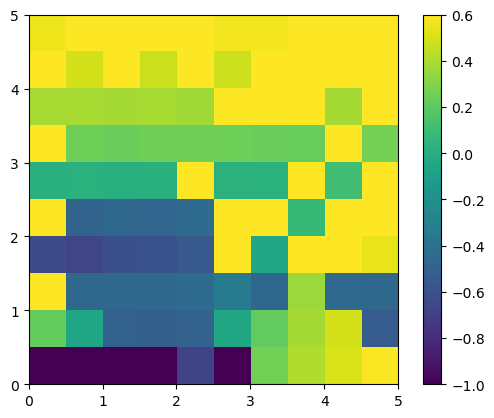

In [52]:
gap = np.asarray(gap, dtype=float)
plt.imshow(np.log10(gap[:,:,0]).T, origin='lower', extent=(0, 5, 0, 5), vmin=-1, vmax=0.6)
plt.colorbar()

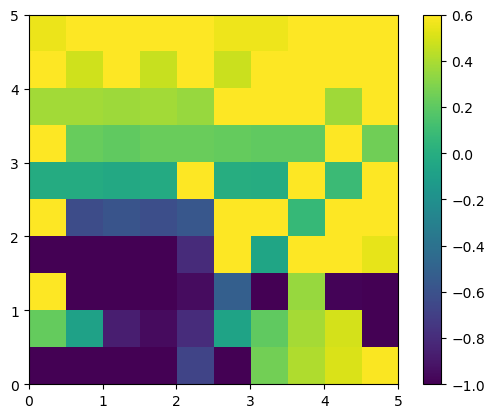

In [55]:
gap = np.asarray(gap, dtype=float)
plt.imshow(np.log10(gap[:,:,1]).T, origin='lower', extent=(0, 5, 0, 5), vmin=-1, vmax=0.6)
plt.colorbar()